In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

class MultipleAnnotators_Classification():
  def __init__(self, output_dim, num_annotators):
    self.K = output_dim
    self.R = num_annotators

  def CrowdLayer(self, input):
    x = keras.layers.Dense(self.R + self.K,activation='tanh')(input)
    output_cla = keras.layers.Dense(self.K, activation='softmax')(x)
    output_ann = keras.layers.Dense(self.R, activation='sigmoid')(x)
    output = keras.layers.Concatenate()([output_cla, output_ann])
    return output

  #RCDNN   
  def loss(self):
        def custom_loss(y_true, y_pred):
            # print(y_true,y_pred)
            pred = y_pred[:, :self.K]
            pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
            ann_ = y_pred[:, self.K:]
            Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
            Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
            p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
            temp1 = ann_*tf.math.log(p_logreg)  
            temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
            # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
            # print(tf.reduce_mean(Y_true,axis=1).numpy())
            return -tf.math.reduce_sum((temp1 + temp2))
        return custom_loss  
    
  @tf.function
  def train_step(self, x, Y, y=None):
      with tf.GradientTape() as tape:
          logits = self.model(x, training=True)
          loss_value = self.loss_fn(Y, logits)
      grads = tape.gradient(loss_value, self.model.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
      if y is not None:
      	self.train_acc_metric.update_state(y, logits[:, :self.K])
      return loss_value

  @tf.function
  def test_step(self, x, y):
      val_logits = self.model(x, training=False)
      self.val_acc_metric.update_state(y, val_logits[:,:self.K])

  def fit(self, model, Data_tr, epochs):
    self.model = model
    # Instantiate an optimizer.
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    # Instantiate a loss function.
    self.loss_fn = self.loss()
    self.train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    

    for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))
      start_time = time.time()

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, Y_batch_train) in enumerate(Data_tr):
          # print(y_batch_train, Y_batch_train)
          loss_value = self.train_step(x_batch_train, Y_batch_train)

          # Log every 200 batches.
          if step % 10 == 0:
              train_acc = self.train_acc_metric.result()
              print(
                  "Training loss (for one batch) at step %d: %.4f, Accuracy: %.4f"
                  % (step, float(loss_value), float(train_acc))
              )
              # print("Seen so far: %d samples" % ((step + 1) * batch_size))

      # Display metrics at the end of each epoch.
      train_acc = self.train_acc_metric.result()
      print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    self.train_acc_metric.reset_states()
    print("Time taken: %.2fs" % (time.time() - start_time))
    return self.model

  def eval_model(self, Data):
    self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    for x_batch_val, y_batch_val in Data:
        self.test_step(x_batch_val, y_batch_val)

    val_acc = self.val_acc_metric.result()
    self.val_acc_metric.reset_states()
    return val_acc
    



In [2]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [3]:
import numpy as np
import pandas as pd
import os 
import csv
import tensorflow as tf
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import keras

# packages for learning from crowds
# from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
# from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys


In [4]:
NUM_RUNS = 15
DATA_PATH_Tr = "../input/labelme-da/Augmented_labelme/Train/"
DATA_PATH_Te = "../input/labelme-da/Augmented_labelme/Test"
DATA_PATH_Val = "../input/labelme/LabelMe/valid"
N_CLASSES = 8
BATCH_SIZE = 64
N_EPOCHS = 50
N_ANNOT = 59

DATA_PATH = '/kaggle/input/labelme/LabelMe/prepared/'

In [5]:
def load_data(filename):
    #f = open(filename)
    data = np.load(filename)  
   # f.close()
    return data

In [6]:
print ("\nLoading train data...")

# images processed by VGG16
data_train_vgg16 = load_data(DATA_PATH+"data_train_vgg16.npy")
print (data_train_vgg16.shape)

# ground truth labels
labels_train = load_data(DATA_PATH+"labels_train.npy")
print (labels_train.shape)

# labels obtained from majority voting
labels_train_mv = load_data(DATA_PATH+"labels_train_mv.npy")
print (labels_train_mv.shape)

# labels obtained by using the approach by Dawid and Skene
labels_train_ds = load_data(DATA_PATH+"labels_train_DS.npy")
print (labels_train_ds.shape)

# data from Amazon Mechanical Turk
print ("\nLoading AMT data...")
answers = load_data(DATA_PATH+"answers.npy")
print (answers.shape)
N_ANNOT = answers.shape[1]
print ("\nN_CLASSES:", N_CLASSES)
print ("N_ANNOT:", N_ANNOT)

# load test data
print ("\nLoading test data...")

# images processed by VGG16
data_test_vgg16 = load_data(DATA_PATH+"data_test_vgg16.npy")
print (data_test_vgg16.shape)

# test labels
labels_test = load_data(DATA_PATH+"labels_test.npy")
print (labels_test.shape)


Loading train data...
(10000, 4, 4, 512)
(10000,)
(10000,)
(10000,)

Loading AMT data...
(10000, 59)

N_CLASSES: 8
N_ANNOT: 59

Loading test data...
(1188, 4, 4, 512)
(1188,)


In [7]:
labels_train

array([4, 5, 5, ..., 2, 2, 2])

In [8]:
def one_hot(target, n_classes):
    targets = np.array([target]).reshape(-1)
    one_hot_targets = np.eye(n_classes)[targets]
    return one_hot_targets

In [9]:
# print ("\nConverting to one-hot encoding...")
# labels_train_bin = one_hot(labels_train, N_CLASSES)
# print (labels_train_bin.shape)
# labels_train_mv_bin = one_hot(labels_train_mv, N_CLASSES)
# print (labels_train_mv_bin.shape)
# labels_train_ds_bin = one_hot(labels_train_ds, N_CLASSES)
# print (labels_train_ds_bin.shape)
# labels_test_bin = one_hot(labels_test, N_CLASSES)
# print (labels_test_bin.shape)

# answers_bin_missings = []
# for i in range(len(answers)):
#     row = []
#     for r in range(N_ANNOT):
#         if answers[i,r] == -1:
#             row.append(-1 * np.ones(N_CLASSES))
#         else:
#             row.append(one_hot(answers[i,r], N_CLASSES)[0,:])
#     answers_bin_missings.append(row)
# answers_bin_missings = np.array(answers_bin_missings).swapaxes(1,2)
# answers_bin_missings.shape

In [10]:
MA = MultipleAnnotators_Classification(N_CLASSES, N_ANNOT)
def build_base_model():
#     base_model = Sequential()
#     base_model.add(Flatten(input_shape=data_train_vgg16.shape[1:]))
#     base_model.add(Dense(128, activation='relu'))
#     base_model.add(Dropout(0.5))
#     base_model.add(Dense(N_CLASSES))
#     base_model.add(Activation("softmax"))
#     base_model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    inputs = keras.layers.Input(shape=data_train_vgg16.shape[1:], name='entrada')
    x = keras.layers.Flatten()(inputs)
    #x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = MA.CrowdLayer(x)
    model = keras.Model(inputs=inputs,outputs=output)
    return model

In [11]:
def eval_model(model, test_data, test_labels):
    # testset accuracy
    preds_test = model.predict(test_data)
    preds_test_num = np.argmax(preds_test, axis=1)
    accuracy_test = 1.0*np.sum(preds_test_num == test_labels) / len(test_labels)

    return accuracy_test

In [12]:
K = N_CLASSES 
R = 59

def custom_loss(y_true, y_pred):
       # print(y_true,y_pred)
    q = 0.001
    pred = y_pred[:, :K]
    pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
    ann_ = y_pred[:, K:]
    # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
    Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=K, axis=1)
    Y_hat = tf.repeat(tf.expand_dims(pred,-1), R, axis = -1)

    p_gcce = Y_true*(1 - Y_hat**q)/q
    temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
    temp2 = (1 - ann_)*(1-(1/K)**q)/q*tf.reduce_sum(Y_true,axis=1)
    return tf.math.reduce_sum((temp1 + temp2))

2023-02-11 06:17:45.954435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 06:17:46.059822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 06:17:46.060676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 06:17:46.061892: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Validation acc: 0.8931
Validation aUc: 0.9338
Validation aUc_Sklearn: 0.9905
Validation Balanced_ACC: 0.8811
Validation MI: 1.6182
Validation Normalized MI: 0.7829
Validation Adjusted MI: 0.7807
Validation acc: 0.8872
Validation aUc: 0.9350
Validation aUc_Sklearn: 0.9910
Validation Balanced_ACC: 0.8764
Validation MI: 1.6172
Validation Normalized MI: 0.7824
Validation Adjusted MI: 0.7801
Validation acc: 0.8981
Validation aUc: 0.9478
Validation aUc_Sklearn: 0.9913
Validation Balanced_ACC: 0.8883
Validation MI: 1.6421
Validation Normalized MI: 0.7946
Validation Adjusted MI: 0.7925
Validation acc: 0.8813
Validation aUc: 0.9505
Validation aUc_Sklearn: 0.9906
Validation Balanced_ACC: 0.8721
Validation MI: 1.6012
Validation Normalized MI: 0.7751
Validation Adjusted MI: 0.7728
Validation acc: 0.8906
Validation aUc: 0.9458
Validation aUc_Sklearn: 0.9904
Validation Balanced_ACC: 0.8790
Validation MI: 1.5996
Validation Normalized MI: 0.7738
Validation Adjusted MI: 0.7715
Validation acc: 0.9024
Va

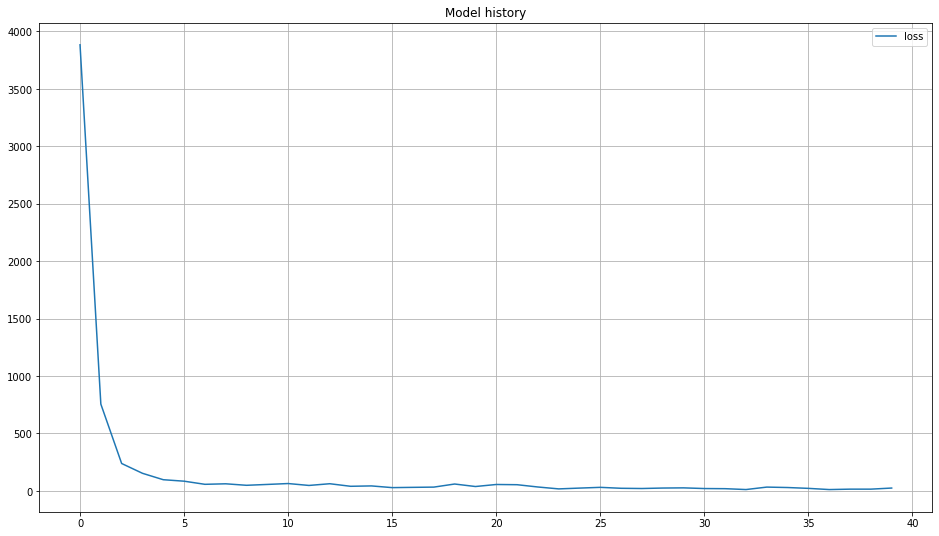

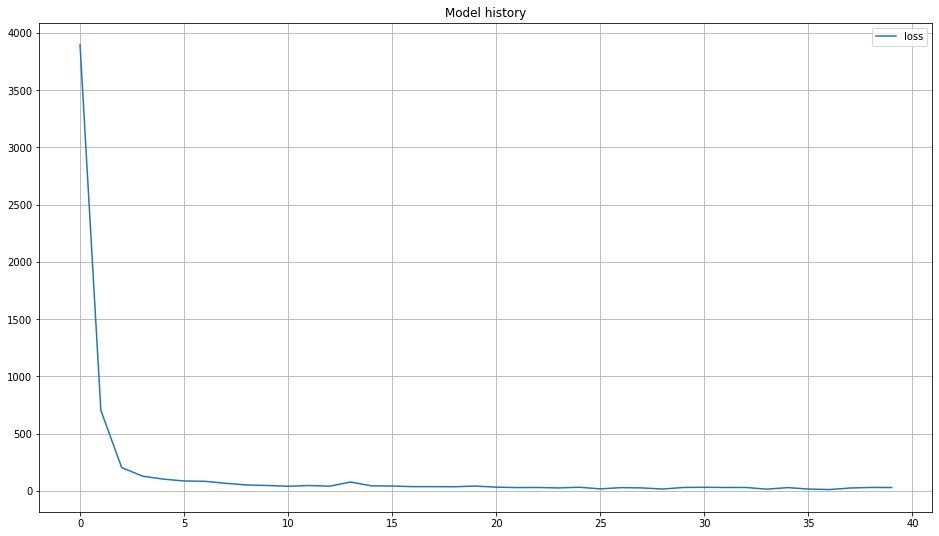

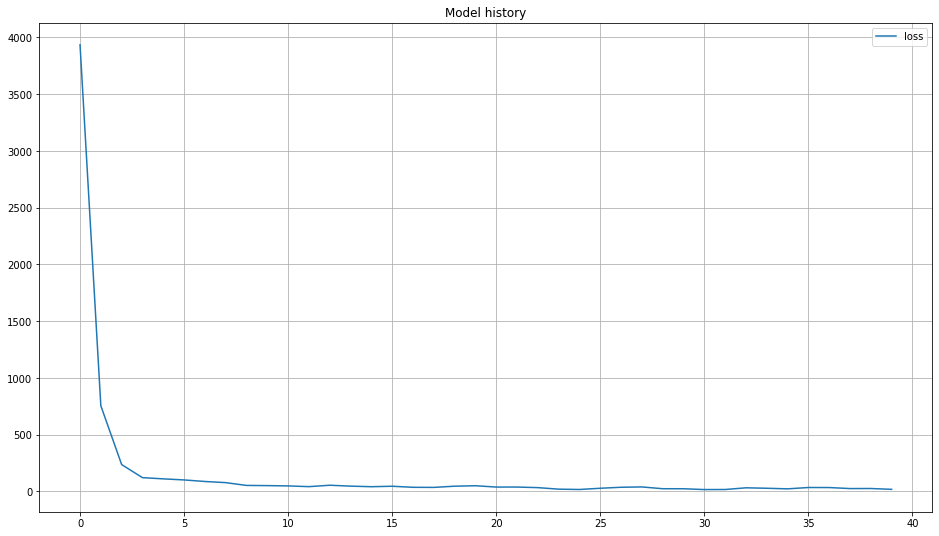

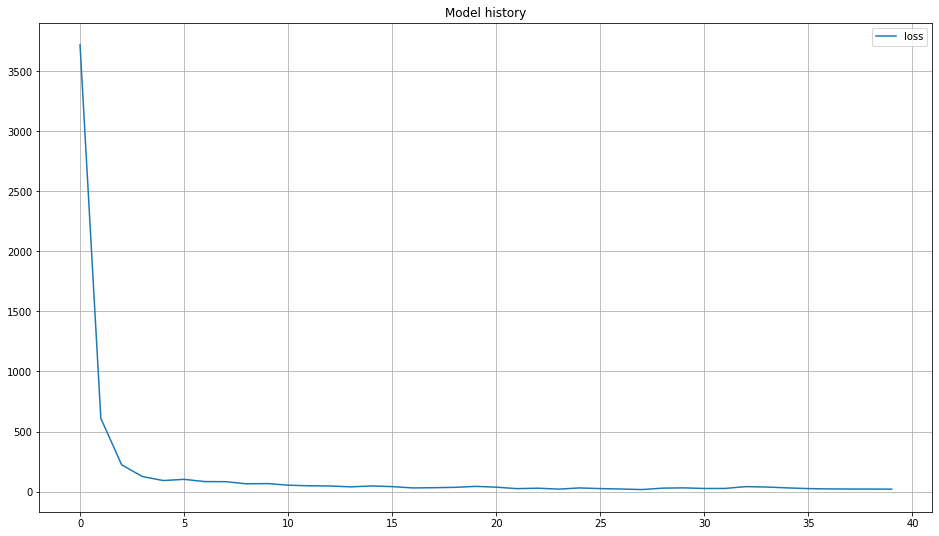

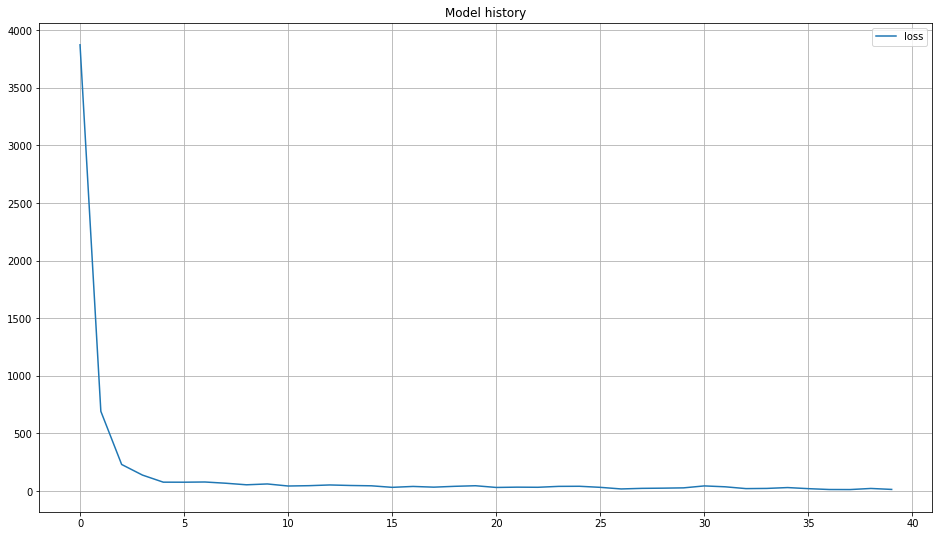

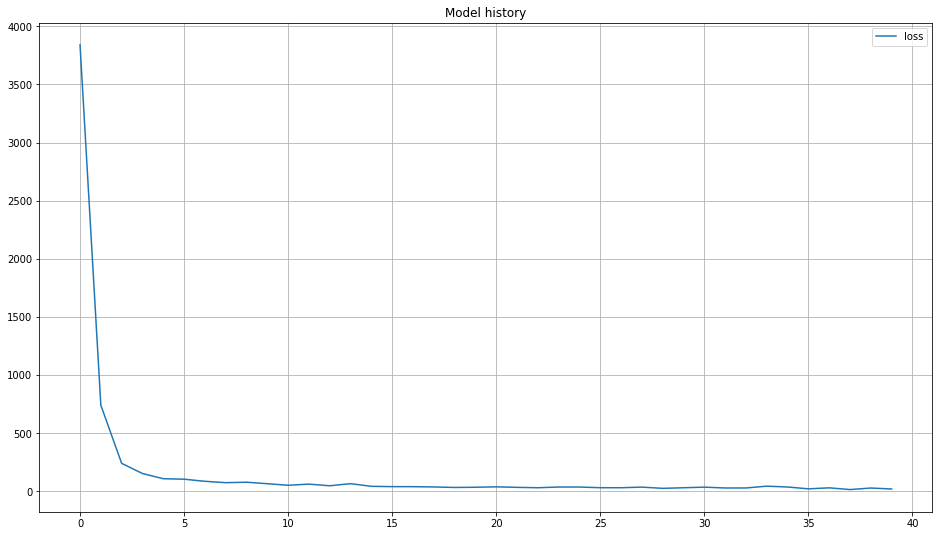

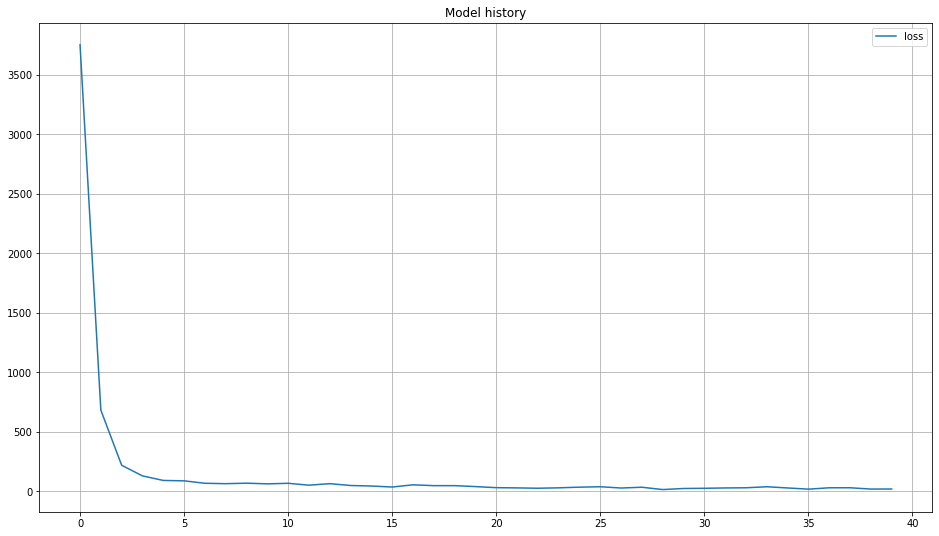

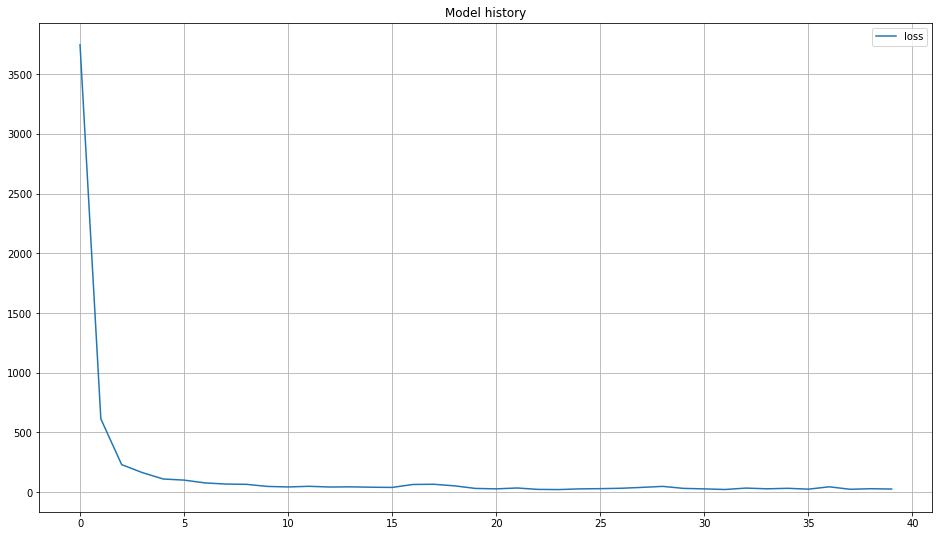

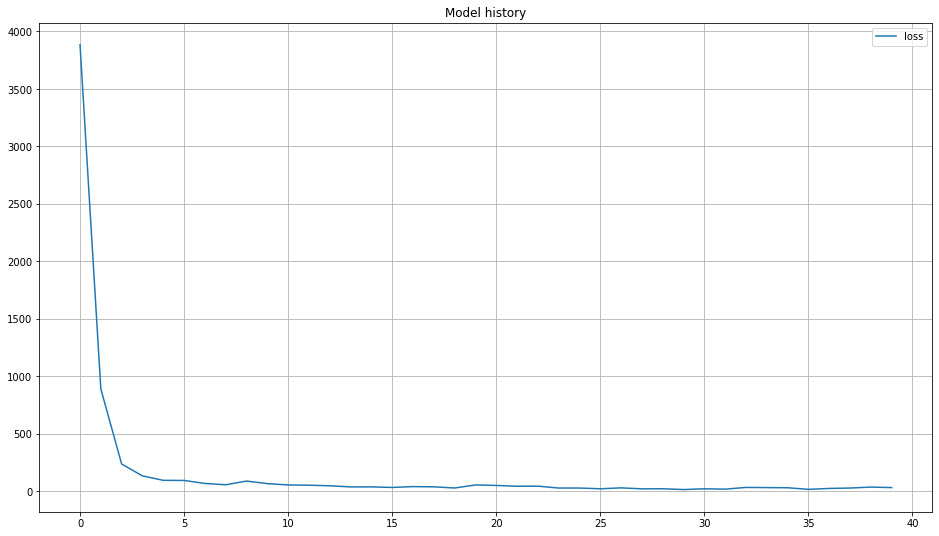

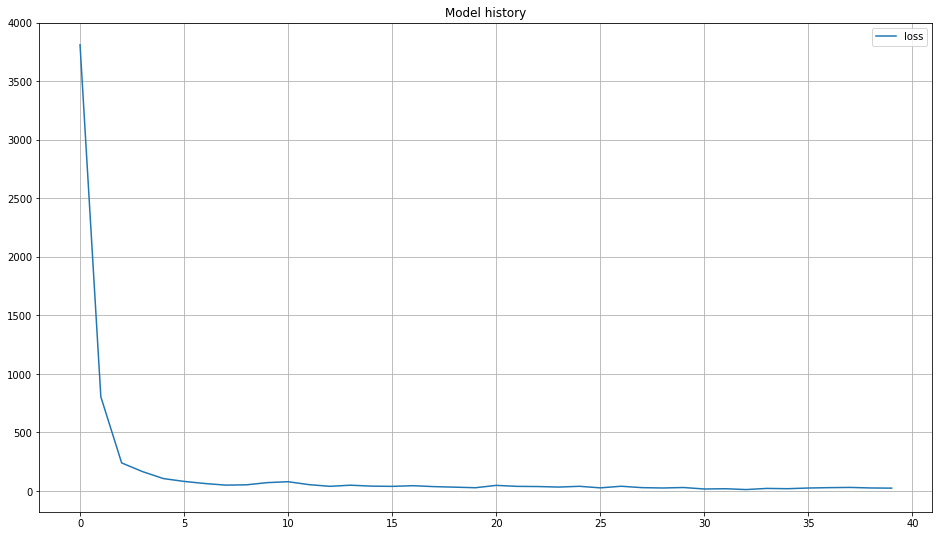

In [13]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score 

NUM_RUNS = 10
N_EPOCHS = 40
N_ANNOT = 59
K= N_CLASSES
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
AUCSK = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
 
for i in range(NUM_RUNS):
    MA = MultipleAnnotators_Classification(N_CLASSES, N_ANNOT)
    model =  build_base_model()
    model.compile(optimizer='adam', loss=custom_loss)
    trainHistory =  model.fit(data_train_vgg16, labels_train, epochs=N_EPOCHS, shuffle=True, batch_size=BATCH_SIZE, verbose=0)
    # Create the history figure
    plt.figure(figsize=(16,9))
    for g in  trainHistory.history:
     plt.plot( trainHistory.history[g],label=g)
    plt.title('Model history')
    plt.legend()
    plt.grid()
    #Accuracy
    
    
    
    pred_2 = model.predict(data_test_vgg16)
 
    report = classification_report( pred_2[:,:N_CLASSES].argmax(axis=1), labels_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation acc: %.4f" % (float(ACC[i]),))
     #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
    val_logits =model.predict(data_test_vgg16) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(labels_test.ravel(), val_logits[:,:N_CLASSES].argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    val_AUC1 = roc_auc_score(ook(labels_test.ravel()), pred_2[:,:N_CLASSES])
    print("Validation aUc_Sklearn: %.4f" % (float(val_AUC1),))
    AUCSK[i] = val_AUC1
    
 
  
    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(labels_test.squeeze(), pred_2[:,:N_CLASSES].argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(labels_test.squeeze(), pred_2[:,:N_CLASSES].argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(labels_test.squeeze(), pred_2[:,:N_CLASSES].argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(labels_test.squeeze(), pred_2[:,:N_CLASSES].argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
#    # val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(labels_test, pred_2[:,:N_CLASSES].argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
#   val_acc[i] = MA.eval_model(Data_test_MA)
#   print("Validation acc: %.4f" % (float(val_acc[i]),))
  
#    #AUC =======================
#   val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
#   for x_batch_val, y_batch_val in Data_test_MA:
#       val_logits = model(x_batch_val.numpy(), training=False)
#       # tf.print(y_batch_val)
#       val_AUC_metric.update_state(y_batch_val, val_logits[:,:N_CLASSES].numpy().argmax(axis=1).astype('float'))

#   val_AUC = val_AUC_metric.result()
#   val_AUC_metric.reset_states()
#   val_AUC = val_AUC.numpy()
#   print("Validation AUC: %.4f" % (float(val_AUC),))
#   AUC[i] = val_AUC
#   #===================================================

In [14]:
ACC

array([0.89309764, 0.88720539, 0.89814815, 0.88131313, 0.89057239,
       0.9023569 , 0.88468013, 0.88804714, 0.88973064, 0.89141414])

In [15]:
AUC

array([0.9337765 , 0.9350192 , 0.94782591, 0.95051706, 0.94582844,
       0.94505137, 0.93430322, 0.96117532, 0.94558454, 0.94720942])

In [16]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average AUCSK: ', np.round( AUCSK.mean(),4)*100) 
print('Average AUCSK std: ',np.round(np.std( AUCSK),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  89.07000000000001
Average std:  0.58
Average AUC:  94.46
Average AUC std:  0.8
Average AUCSK:  99.1
Average AUCSK std:  0.05
Average Balanced Accuracy:  88.07000000000001
Average std:  0.62
Average MI:  161.61
Average std:  1.9900000000000002
Average Normalized MI:  78.19
Average std:  0.95
Average Ajdusted MI:  77.96
Average std:  0.96


In [17]:
import pickle

# create the dictionary with 6 scalar variables
Metrics = {
    'Accuracy': np.round( ACC.mean(),4)*100,
    'Accuracy_std': np.round(np.std( ACC),4)*100,
    'AUC': np.round( AUC.mean(),4)*100,
    'AUC_std': np.round(np.std( AUC),4)*100,
    'AUCSK': np.round( AUCSK.mean(),4)*100,
    'AUCSK_std': np.round(np.std( AUCSK),4)*100,
    'Balanced Accuracy': np.round( BACC.mean(),4)*100,
    'Balanced Accuracy_std':  np.round(np.std(BACC),4)*100,
    'MI': np.round( MI.mean(),4)*100,
    'MI_std': np.round(np.std(MI),4)*100,
    'Normalized MI': np.round( NMI.mean(),4)*100,
    'Normalized MI_std': np.round(np.std(NMI),4)*100,
    'Adjusted MI': np.round( AMI.mean(),4)*100,
    'Adjusted MI_std': np.round(np.std(NMI),4)*100,
}

# save the dictionary to a file using pickle
with open('data.pickle', 'wb') as handle:
    pickle.dump(Metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
Metrics

{'Accuracy': 89.07000000000001,
 'Accuracy_std': 0.58,
 'AUC': 94.46,
 'AUC_std': 0.8,
 'AUCSK': 99.1,
 'AUCSK_std': 0.05,
 'Balanced Accuracy': 88.07000000000001,
 'Balanced Accuracy_std': 0.62,
 'MI': 161.61,
 'MI_std': 1.9900000000000002,
 'Normalized MI': 78.19,
 'Normalized MI_std': 0.95,
 'Adjusted MI': 77.96,
 'Adjusted MI_std': 0.95}